# Imports

In [2]:
# Data Processing
import pandas as pd 
import numpy as np 
import scipy.io 

import time
import random 

# Plotting 
from matplotlib import pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib import style
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.image as mpimg 

plt.rcParams['animation.ffmpeg_path'] = "C:\\ffmpeg\\bin\\ffmpeg.exe"

import seaborn as sns

style.use('ggplot')

# Machine Learning 
import sklearn 

# Models 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 

# Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Preprocessing 
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 

# Saving models 
from sklearn.externals import joblib

C:\Users\vatsa\Miniconda3\envs\indoor_location_v2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Now to get the data and do some basic processing. 

In [3]:
emitter_mat = scipy.io.loadmat("Emitter_cir_noise.mat")
cal_cir_mat = scipy.io.loadmat("cal_cir_noise.mat")
dataset_mat = scipy.io.loadmat("dataset_cir.mat")

emitter_df = pd.DataFrame(emitter_mat['Emitter_cir_noise'])
cal_cir_df = pd.DataFrame(cal_cir_mat['cal_cir_noise'])
dataset_df = pd.DataFrame(dataset_mat['dataset_cir'])

In [4]:
def create_noisy_dataset(X):
    noise = np.zeros(X.shape)
    for idx, column in enumerate(X):
        mu, sigma = X[column].mean(), X[column].std()
        noise_factor = 0.1
        noise[:, idx] = np.random.normal(0, noise_factor*sigma, [X.shape[0], 1]).ravel()

    X_noisy = X + noise
    return X_noisy 

def process_data(debug=False):        
    if debug:
        print(emitter_df.head())
        print(cal_cir_df.head())
        print(dataset_df.head())
    
    comb_dataset_df = pd.concat([dataset_df, cal_cir_df, emitter_df], ignore_index=True)
    comb_dataset_df = comb_dataset_df.drop(columns=2) # Drop the third column 

    if debug:
        print(comb_dataset_df.shape)
        print(comb_dataset_df.head())
        print(comb_dataset_df.describe())

    # Split the dataset into X and y. 
    X = comb_dataset_df.drop(columns=[0,1])
    X_noisy = create_noisy_dataset(X)
    y_lat = comb_dataset_df.iloc[:, :1]
    y_long = comb_dataset_df.iloc[:, 1:2]

    if debug:
        print("X: ", X.head())
        print("y long: ", y_long.head())
        print("y_lat: ", y_lat.head())
    
    return X, X_noisy, y_lat, y_long

Now to create a pipeline for handling preprocessing such as MinMax Scaling and potential imputation. 

In [5]:
X, X_noisy, y_lat, y_long = process_data(debug=False)

pca = PCA(n_components=15)

X_knn_pipeline = Pipeline([
   ('norm', Normalizer()),    
    ('PCA', pca)
])

X_nn_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

y_lat_pipeline = Pipeline([
    ('quantile_transform', QuantileTransformer(n_quantiles=10, output_distribution='normal'))
])

y_long_pipeline = Pipeline([
    ('quantile_transform', QuantileTransformer(n_quantiles=10, output_distribution='normal'))
])

Now to scale the dataset and then split it into a training and testing set. 

In [6]:
X_knn = X_knn_pipeline.fit_transform(X)
X_noisy_knn = X_knn_pipeline.fit_transform(X_noisy)

X_nn = X_nn_pipeline.fit_transform(X)
X_noisy_nn = X_nn_pipeline.fit_transform(X_noisy)

y_lat_tr = y_lat_pipeline.fit_transform(y_lat)
y_long_tr = y_long_pipeline.fit_transform(y_long)

In [7]:
print("PCA Explained Variance: {}".format(pca.explained_variance_ratio_))

PCA Explained Variance: [0.31055148 0.23682946 0.11634336 0.05033849 0.04063235 0.03579855
 0.02760083 0.01916033 0.01572485 0.01247687 0.01081801 0.00893692
 0.00892522 0.00726499 0.00640458]


Split the data into training and testing set. 

In [8]:
X = np.array(X)
X_noisy = np.array(X_noisy)
y = np.concatenate((y_lat_tr, y_long_tr), axis=1)

train_size = dataset_df.shape[0]
val_size = cal_cir_df.shape[0]

def split_data(X):
    X_train = X[:train_size, :]
    X_val = X[train_size:train_size+val_size, :]
    X_enhanced = X[:train_size+val_size, :]
    X_test = X[train_size + val_size:, :]
    return X_train, X_val, X_enhanced, X_test 

X_rf_train, X_rf_val, X_rf_enhanced, X_rf_test = split_data(X)
X_rf_noisy_train, X_rf_noisy_val, X_rf_noisy_enhanced, X_rf_noisy_test = split_data(X_noisy)
X_knn_train, X_knn_val, X_knn_enhanced, X_knn_test = split_data(X_knn)
X_knn_noisy_train, X_knn_noisy_val, X_knn_noisy_enhanced, X_knn_noisy_test = split_data(X_noisy_knn)
X_nn_train, X_nn_val, X_nn_enhanced, X_nn_test = split_data(X_nn)
X_nn_noisy_train, X_nn_noisy_val, X_nn_noisy_enhanced, X_nn_noisy_test = split_data(X_noisy_nn)

y_train, y_val, y_enhanced, y_test = split_data(y)

# Multivariate Regression 

In [9]:
def train(model, X, y): 
    model.fit(X, y)
    model_scores = cross_val_score(model, X, y,
                                   scoring='neg_mean_squared_error', cv=3)
    rmse_scores = np.sqrt(-model_scores)
  
    # Display the scores 
    print("Scores:", rmse_scores)
    print("Mean:", rmse_scores.mean())
    print("Standard deviation:", rmse_scores.std())

def error_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
 
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    lat_rmse = np.sqrt(mean_squared_error(y_test_lat, y_pred_lat))
    long_rmse = np.sqrt(mean_squared_error(y_test_long, y_pred_long))
    error_dist = np.sqrt(lat_rmse**2 + long_rmse**2)

    return lat_rmse, long_rmse, error_dist

def plot_2D_predictions(model, range_beg, range_end, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.title(title)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    
    y_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.xlim(int(y_lat.min()) - 150, int(y_lat.max()) + 150)
    plt.ylim(int(y_long.min()) - 150, int(y_long.max()) + 150)

    plt.plot([y_pred_lat.squeeze(),y_test_lat.squeeze()], 
             [y_pred_long.squeeze(),y_test_long.squeeze()], color='red', marker='.')

    plt.plot(y_pred_lat[range_beg:range_end], y_pred_long[range_beg:range_end], 'g.')
    plt.plot(y_test_lat[range_beg:range_end], y_test_long[range_beg:range_end], 'b.')
    plt.show()
    
def run_model(model, X_train, y_train, X_test, y_test, filename=None, save=False):
    print("Training ...")
    train(model, X_train, y_train)
    print("Training completed.")
    model_lat_rmse, model_long_rmse = rmse(model, X_test, y_test)
    if save and filename:
        joblib.dump(model, filename)
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure() 
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,1])
    plt.legend()
    plt.show()
    
def get_metrics(model, X_val, X_test, title, y_val=y_val, y_test=y_test):
    val_lat_rmse, val_long_rmse, val_error_dist = error_metrics(model, X_val, y_val)
    print("Valid Lat RMSE: {:.2f}, Long RMSE: {:.2f}, Euclidean Error: {:.2f}".format(val_lat_rmse, 
                                                                                   val_long_rmse, 
                                                                                   val_error_dist))
    test_lat_rmse, test_long_rmse, test_error_dist = error_metrics(model, X_test, y_test)
    print("Test Lat RMSE: {:.2f}, Long RMSE: {:.2f}, Euclidean Error: {:.2f}".format(test_lat_rmse, 
                                                                      test_long_rmse, 
                                                                      test_error_dist))


    plot_2D_predictions(model, 1, len(y_val), X_val, y_val, "Validation: " + title)
    plot_2D_predictions(model, 1, len(y_test), X_test, y_test, "Testing: " + title)

## Random Forest Regression

### Non-enhanced Dataset 

Valid Lat RMSE: 165.33, Long RMSE: 36.13, Euclidean Error: 169.23
Test Lat RMSE: 43.81, Long RMSE: 5.14, Euclidean Error: 44.11


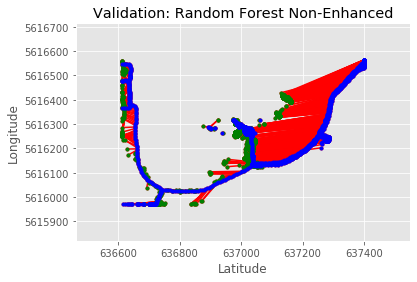

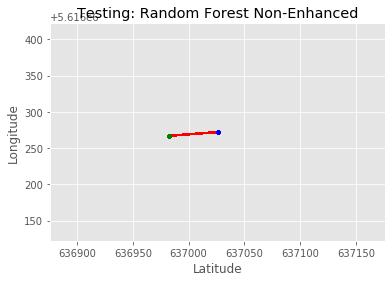

In [10]:
train_flag = False  
filename="./Regression Models/rf_vanilla.sav"

if train_flag:
    rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
    run_model(rf_reg, X_rf_train, y_train, X_rf_test, y_test, filename, True)
else:
    rf_reg = joblib.load(filename)

get_metrics(model=rf_reg, X_val=X_rf_val, X_test=X_rf_test, title="Random Forest Non-Enhanced")

#### Noise Evaluation

Valid Lat RMSE: 164.92, Long RMSE: 43.28, Euclidean Error: 170.50
Test Lat RMSE: 35.86, Long RMSE: 21.46, Euclidean Error: 41.79


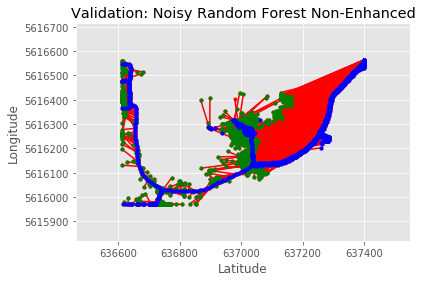

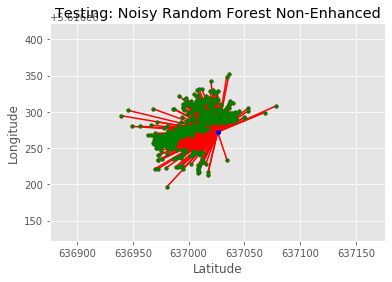

In [11]:
get_metrics(model=rf_reg, X_val=X_rf_noisy_val, X_test=X_rf_noisy_test, title="Noisy Random Forest Non-Enhanced")

### Enhanced Dataset 

Valid Lat RMSE: 2.41, Long RMSE: 1.83, Euclidean Error: 3.02
Test Lat RMSE: 0.00, Long RMSE: 0.41, Euclidean Error: 0.41


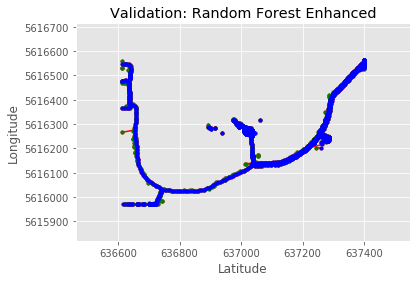

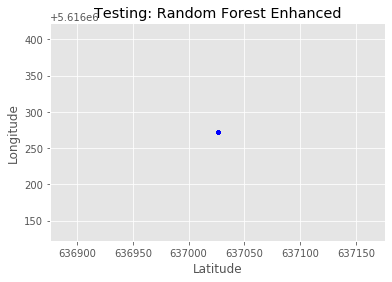

In [12]:
train_flag = False 
filename="./Regression Models/rf_enhanced_vanilla.sav"

if train_flag:
    rf_reg_enhanced = RandomForestRegressor(n_estimators=10, random_state=42)
    run_model(rf_reg_enhanced, X_rf_enhanced, y_enhanced, X_rf_test, y_test, filename, save=True)
else: 
    rf_reg_enhanced = joblib.load(filename)
    
get_metrics(model=rf_reg_enhanced, X_val=X_rf_val, X_test=X_rf_test, title="Random Forest Enhanced")

#### Noise Evaluation

Valid Lat RMSE: 26.12, Long RMSE: 21.93, Euclidean Error: 34.11
Test Lat RMSE: 19.63, Long RMSE: 20.96, Euclidean Error: 28.72


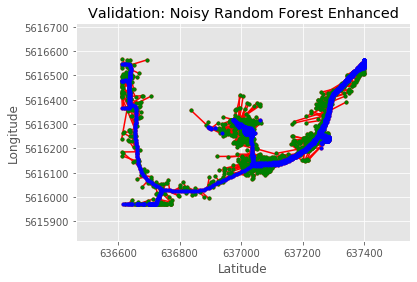

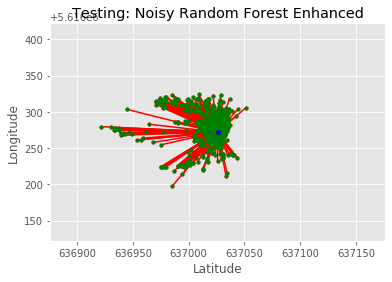

In [13]:
get_metrics(model=rf_reg_enhanced, X_val=X_rf_noisy_val, X_test=X_rf_noisy_test, title="Noisy Random Forest Enhanced")

## KNeighbors Regression 

### Non-enhanced Dataset 

Valid Lat RMSE: 87.95, Long RMSE: 101.64, Euclidean Error: 134.41
Test Lat RMSE: 14.63, Long RMSE: 19.49, Euclidean Error: 24.37


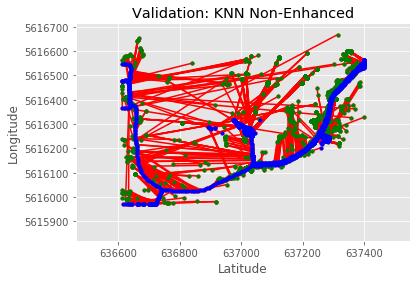

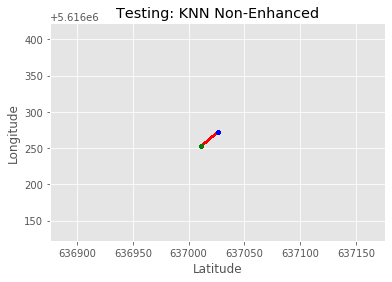

In [14]:
train_flag = False 
filename="./Regression Models/knn_normalized.sav"

if train_flag: 
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='distance')
    run_model(knn_reg, X_knn_train, y_train, X_knn_test, y_test, filename, save=True)
else:
    knn_reg = joblib.load(filename)

get_metrics(model=knn_reg, X_val=X_knn_val, X_test=X_knn_test, title="KNN Non-Enhanced")

#### Noise Evaluation

Valid Lat RMSE: 149.15, Long RMSE: 133.45, Euclidean Error: 200.14
Test Lat RMSE: 164.48, Long RMSE: 232.64, Euclidean Error: 284.91


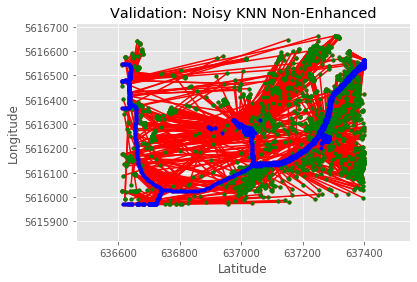

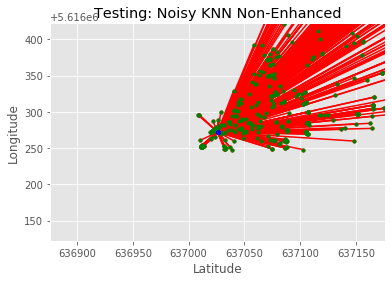

In [15]:
get_metrics(model=knn_reg, X_val=X_knn_noisy_val, X_test=X_knn_noisy_test, title="Noisy KNN Non-Enhanced")

### Enhanced Dataset 

Valid Lat RMSE: 0.62, Long RMSE: 1.21, Euclidean Error: 1.36
Test Lat RMSE: 0.03, Long RMSE: 0.41, Euclidean Error: 0.41


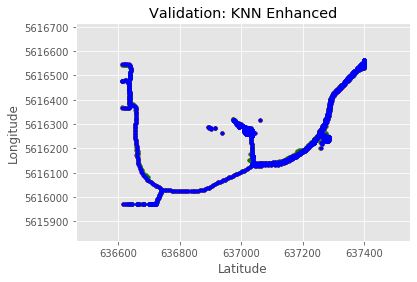

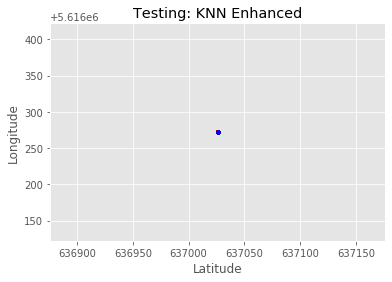

In [16]:
filename="./Regression Models/knn_enhanced_normalized.sav"
train_flag = False 

if train_flag:
    knn_reg_enhanced = KNeighborsRegressor(n_neighbors=10, weights='distance')
    run_model(knn_reg_enhanced, X_knn_enhanced, y_enhanced, X_knn_test, y_test, filename, save=True)
else:
    knn_reg_enhanced = joblib.load(filename)

get_metrics(model=knn_reg_enhanced, X_val=X_knn_val, X_test=X_knn_test, title="KNN Enhanced")

#### Noise Evaluation 

Valid Lat RMSE: 138.80, Long RMSE: 126.60, Euclidean Error: 187.87
Test Lat RMSE: 163.76, Long RMSE: 230.30, Euclidean Error: 282.59


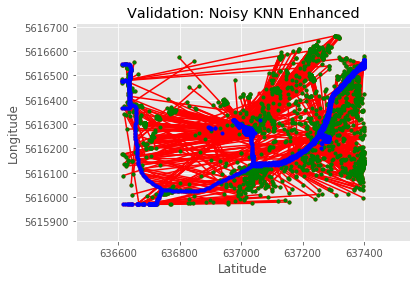

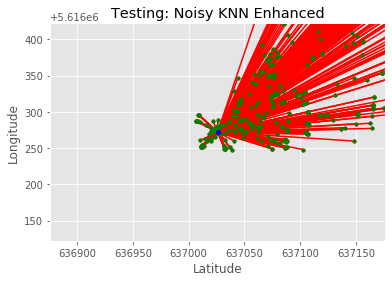

In [17]:
get_metrics(model=knn_reg_enhanced, X_val=X_knn_noisy_val, X_test=X_knn_noisy_test, title="Noisy KNN Enhanced")

## DNN Regression

In [20]:
import tensorflow.keras 
from tensorflow.keras import layers 
import tensorflow as tf

def build_model(X):
    print(X.shape)
    model = keras.Sequential([
    layers.Dense(20, activation='relu', kernel_initializer='normal', input_shape=(X.shape[1],)),
    layers.Dense(2, activation='linear')])

    optimizer = keras.optimizers.Adam()
    
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def train_model(X, y, filename, save=False):
    model = build_model(X)
    print(model.summary())

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X, y, epochs=100,
                        validation_split = 0.2, verbose=1, callbacks=[early_stop])
    plot_history(history)
    
    if save:
        # Save the weights
        model.save_weights('./Regression Models/{}_model_weights.h5'.format(filename))

        # Save the model architecture
        with open('./Regression Models/{}_model_architecture.json'.format(filename), 'w') as f:
            f.write(model.to_json())
    
    return model 

### Non-enhanced Dataset 

Valid Lat RMSE: 300.52, Long RMSE: 38.96, Euclidean Error: 303.03
Test Lat RMSE: 368.85, Long RMSE: 32.09, Euclidean Error: 370.25


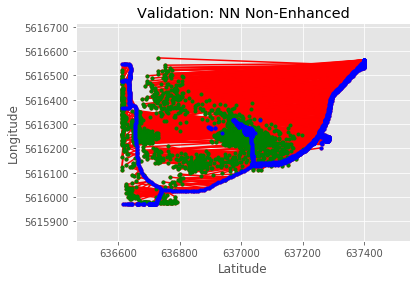

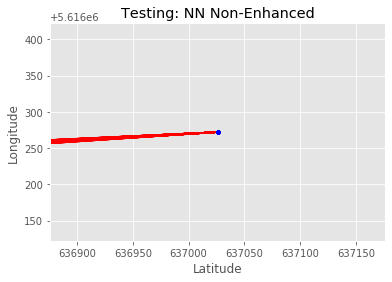

In [23]:
filename = "normal"
train_flag = False
if train_flag:
    model = train_model(X_nn_train, y_train, filename, True)

# Model reconstruction from JSON file
with open('./Regression Models/normal_model_architecture.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
# Load weights into the new model
model.load_weights('./Regression Models/normal_model_weights.h5')

get_metrics(model=model, X_val=X_nn_val, X_test=X_nn_test, title="NN Non-Enhanced")

#### Noise Evaluation 

Valid Lat RMSE: 251.62, Long RMSE: 41.31, Euclidean Error: 254.99
Test Lat RMSE: 331.00, Long RMSE: 27.92, Euclidean Error: 332.18


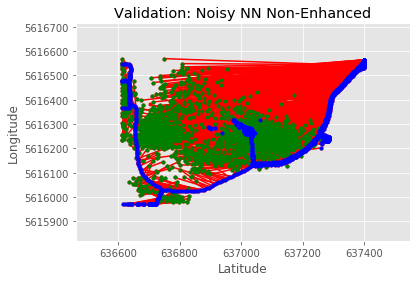

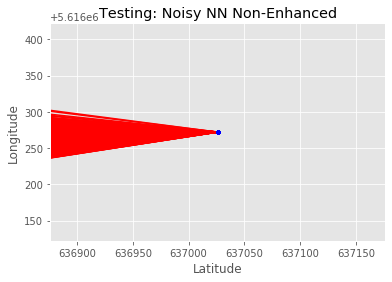

In [24]:
get_metrics(model=model, X_val=X_nn_noisy_val, X_test=X_nn_noisy_test, title="Noisy NN Non-Enhanced")

### Enhanced Dataset 

Valid Lat RMSE: 178.71, Long RMSE: 67.26, Euclidean Error: 190.95
Test Lat RMSE: 345.34, Long RMSE: 24.95, Euclidean Error: 346.24


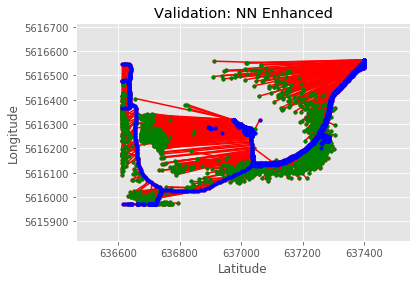

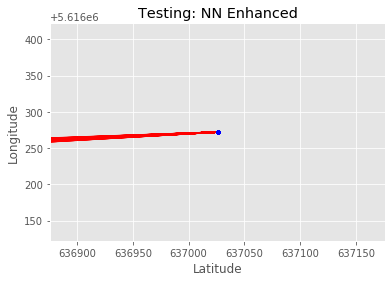

In [26]:
filename = "enhanced"
train_flag = False 
if train_flag: 
    model_enhanced = train_model(X_nn_enhanced, y_enhanced, filename, save=True)

# Model reconstruction from JSON file
with open('./Regression Models/enhanced_model_architecture.json', 'r') as f:
    model_enhanced = tf.keras.models.model_from_json(f.read())
# Load weights into the new model
model_enhanced.load_weights('./Regression Models/enhanced_model_weights.h5')

get_metrics(model=model_enhanced, X_val=X_nn_val, X_test=X_nn_test, title="NN Enhanced")

#### DNN Noise Evaluation 

Valid Lat RMSE: 162.28, Long RMSE: 117.90, Euclidean Error: 200.59
Test Lat RMSE: 287.63, Long RMSE: 101.69, Euclidean Error: 305.08


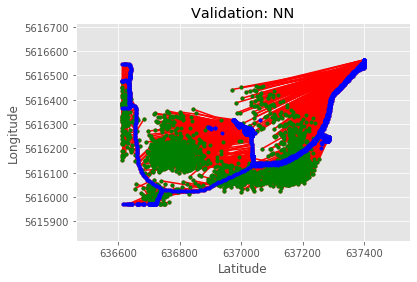

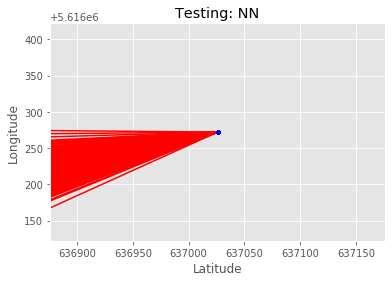

In [27]:
get_metrics(model=model_enhanced, X_val=X_nn_noisy_val, X_test=X_nn_noisy_test, title="NN")

In [29]:
def get_error_list(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))

    euclidean_error = np.sqrt((y_pred_long-y_test_long)**2 + (y_pred_lat-y_test_lat)**2)
    
    return euclidean_error

y_val_lat = y_lat_pipeline.inverse_transform(y_val[:, 0].reshape(-1,1))
y_val_long = y_long_pipeline.inverse_transform(y_val[:, 1].reshape(-1,1))

rf_errors = np.array(get_error_list(rf_reg, X_rf_val, y_val)).ravel()
knn_errors = np.array(get_error_list(knn_reg, X_knn_val, y_val)).ravel()
dnn_errors = np.array(get_error_list(model, X_nn_val, y_val)).ravel()

num_points = y_val_lat.shape[0]

# 2D Animations 

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib 

xlim1 = 636500
xlim2 = 638035
ylim1 = 5615950
ylim2 = 5617485

# Change error here based on what you want to plot 
errors = dnn_errors 

fig, ax = plt.subplots(figsize=(15, 15))
img = plt.imread('base.png')
ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)
x, y, s, c = [],[],[],[]
sc = ax.scatter(x,y,c=c, s=100,cmap='hot', vmin=0, vmax=1000) 
plt.xlim(xlim1, xlim2) 
plt.ylim(ylim1, ylim2)

def animate(i):
    x.append(y_val_lat[i])
    y.append(y_val_long[i])
    c.append(errors[i])
    sc.set_offsets(np.c_[x,y])
    sc.set_array(np.reshape(np.array(c), (-1,)))

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=num_points, interval=10, repeat=True) 
plt.colorbar(sc)
plt.show()

In [ ]:
HTML(ani.to_html5_video())

# Create table of errors for each of the latitudes and longitudes

In [30]:
err_table = pd.DataFrame({
    'Latitude': y_val_lat.reshape(-1,1).flatten(),
    'Longitude': y_val_long.reshape(-1,1).flatten(),
    'RF': rf_errors.reshape(-1,1).flatten(),
    'KNN': knn_errors.reshape(-1,1).flatten(),
    'DNN': dnn_errors.reshape(-1,1).flatten(),
})

In [31]:
err_table
err_table.to_csv('regression_errors.csv')

# Saving Model Pipelines

In [32]:
joblib.dump(X_knn_pipeline, 'Pipelines/knn_pipeline.joblib')
joblib.dump(X_nn_pipeline, 'Pipelines/nn_pipeline.joblib')
joblib.dump(y_lat_pipeline, 'Pipelines/y_lab_pipeline.joblib')
joblib.dump(y_long_pipeline, 'Pipelines/y_long_pipeline.joblib')

['Pipelines/y_long_pipeline.joblib']